# AI - CA5 - CNN
## Arian Firoozi
## 810100196

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch
import matplotlib.image as mpimg
from PIL import Image
from torch.utils.data import DataLoader

### PreProcess:

1. MyDataset is a dataset based on PyTorch Dataset. Methods for printing images and applying filters are implemented for ease of use in this project. Basic filters -Resize and -Grayscale are applied in initialization phase to unify entire dataset.

In [2]:
!gdown --id '1dp1AzTaXIQeGE58CqeO4UclplA28Q5C9'
import zipfile

with zipfile.ZipFile('/content/AI-CA5-Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1dp1AzTaXIQeGE58CqeO4UclplA28Q5C9
To: /content/AI-CA5-Dataset.zip
100% 25.6M/25.6M [00:00<00:00, 57.1MB/s]


In [3]:
from torchvision import datasets, transforms
from torch.utils.data import Dataset
TEST_PERCENT = 20

# dataset_path = "c:/Users/arian/Desktop/AI-CA5-Dataset/"
dataset_path = "/content/AI-CA5-Dataset"

class MyDataset(Dataset):
    def __init__(self, dataset_path):
        self.path = dataset_path
        self.transform = transforms.Compose([transforms.Resize((512, 512)),
                                            transforms.Grayscale(),
                                            transforms.RandomHorizontalFlip(p=0.5),
                                            transforms.ToTensor()])
        self.str_labels = os.listdir(dataset_path)
        self.labels = range(len(self.str_labels))
        self.image_paths = {}
        self.images = {}
        self.test = {}
        self.train = {}

    def __len__(self):
        return np.sum([len(self.images[label]) for label in self.labels])

    def __getitem__(self, index):
        for label in self.labels:
            if index >= len(self.images[label]):
                index-=len(self.images[label])
                continue
            return self.images[label][index], label
        return None, None

    def get_train_test(self, test_percent = TEST_PERCENT, seed=196):
        # random.seed(seed)

        for label in self.labels:
            test_num = int(len(self.images[label]) * test_percent / 100)
            test = random.sample(range(len(self.images[label])), test_num)
            train = np.setdiff1d([i for i in range(len(self.images[label]))], test)
            self.test[label] = [self.images[label][idx] for idx in test]
            self.train[label] = [self.images[label][idx] for idx in train]

    def display_samples(self):
        self.transform_images(transforms.ToPILImage())
        fig = plt.figure(figsize=(15, 7))
        i = 0
        for label in self.labels:
            i+=1
            fig.add_subplot(1, len(self.labels), i)
            idx = random.randint(0, len(self.images[label]))
            plt.imshow(self.images[label][idx])
            plt.axis('off')
            plt.title(self.str_labels[label] + ', image number = ' + str(idx))
        plt.show()
        self.transform_images(transforms.ToTensor())

    def get_labels(self):
        return self.labels

    def show_img(self, label, img_num):
        self.transform_images(transforms.ToPILImage())
        plt_img = plt.imshow(self.images[label][img_num])
        plt.title(self.str_labels[label] + ', image number = ' + str(img_num))
        plt.axis('off')
        plt.show(plt_img)
        self.transform_images(transforms.ToTensor())

    def get_image_paths(self):
        for label in self.labels:
            self.image_paths[label] = []
            img_list = os.listdir(dataset_path + '/' + self.str_labels[label])
            for img in img_list:
                if img.endswith('.jpg'):
                    img_path = dataset_path + '/' + self.str_labels[label] + '/' + img
                    self.image_paths[label].append(img_path)

    def get_images(self):
        self.get_image_paths()
        for label in self.labels:
            self.images[label] = []
            for img_path in self.image_paths[label]:
                img = Image.open(img_path)
                img = self.transform(img)
                self.images[label].append(img)

    def transform_images(self, transform):
        for label in self.labels:
            for i in range(len(self.images[label])):
                self.images[label][i] = transform(self.images[label][i])

    def normalize(self):
        self.transform_images(transforms.ToTensor())

    def to_pil(self):
        self.transform_images(transforms.ToPILImage())

In [4]:
df = MyDataset(dataset_path)
df.get_images()

2. Images already resiezed in initialization process.

3. Normalization rearrenges values of pixels to a specific range. This can lead to easier learning process since range of values is known, also, normalizing image adds higher contrast to picture, seperating lighter and darker areas more, which is also easier to learn. In our example, all tensor values are already in 0 to 1 range and there is no point in normalizing pixels again.

4. Test and train is implemented below in a similiar fashion to prior projects. Test percentage is 20%.

In [5]:
from copy import deepcopy

df.get_train_test()
df_train = df
df_test = deepcopy(df)
df_test.images = df.test
df_train.images = df_train.train

5.

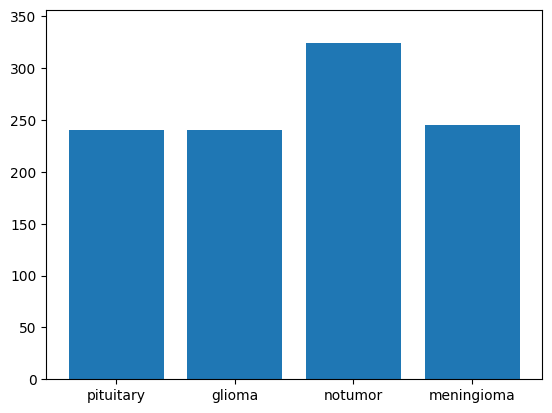

In [6]:
distribution = [len(df.images[l]) for l in df.images]
plt.bar(df.str_labels, distribution)
plt.ylim(0,max(distribution)*1.1)
plt.show()

6. Samples are shown below via built-in functions of previously defined class.

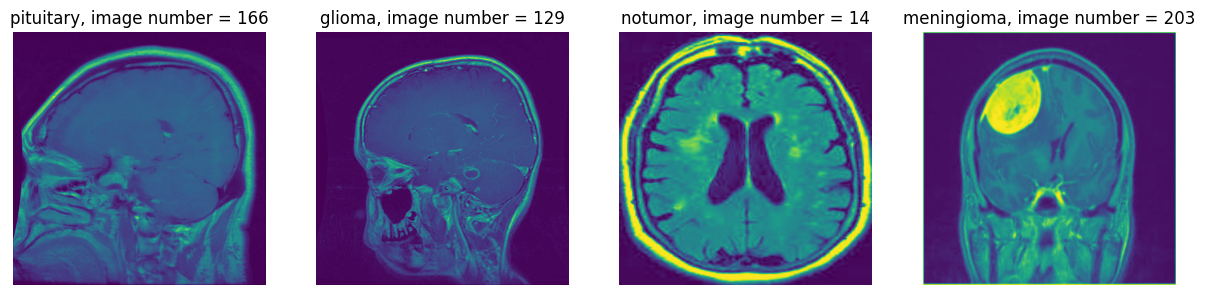

In [7]:
random.seed(196)
df.display_samples()

### CNN Architecture

Multiple CNN designs are usable for tumor detection such as AlexNet, GoogLeNet, VGG and ResNet.

CNN model is implemented below. Structure used is a simplified version of VGG which is a widley used image processing model. The model simply combines multiple layers of convolution layers and one classification layer which uses linear function to calculate the results. Original model was too large to run on Google Colab, therefor my model has fewer layers than a standard VGG.

In [86]:
from torch import nn
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class CNNModule(nn.Module):
    def __init__(self, inp, out):
        super(CNNModule, self).__init__()
        self.layers = []

        self.l1 = nn.Sequential(
                            self.conv_layer(inp, 8),
                            nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.ReLU(),
                            self.conv_layer(8, 16),
                            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.MaxPool2d(kernel_size=2, stride=2),
                            nn.ReLU()
                          )

        self.add_layer(self.l1)

        self.l2 = nn.Sequential(
                            self.conv_layer(16, 32),
                            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.ReLU(),
                            self.conv_layer(32, 64),
                            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.MaxPool2d(kernel_size=2, stride=2),
                            nn.ReLU()
                          )

        self.add_layer(self.l2)

        self.l3 = nn.Sequential(
                            self.conv_layer(64, 64),
                            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.ReLU(),
                            self.conv_layer(64, 64),
                            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.MaxPool2d(kernel_size=2, stride=2),
                            nn.ReLU()
                          )

        self.add_layer(self.l3)

        self.l4 = nn.Sequential(
                            self.conv_layer(64, 32),
                            nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.ReLU(),
                            self.conv_layer(32, 16),
                            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
                            nn.MaxPool2d(kernel_size=2, stride=2),
                            nn.ReLU()
                          )
        self.add_layer(self.l4)

        self.classifier = nn.Sequential(
                          nn.Flatten(),
                          nn.Linear(4 * 16 * 16 *16, 1024),
                          nn.Dropout(p=0.5),
                          nn.ReLU(),
                          nn.Linear(1024, 256),
                          nn.Dropout(p=0.5),
                          nn.ReLU(),
                          nn.Linear(256, out),
                          nn.Softmax(dim=1),
                          ).to(DEVICE)

    def add_layer(self, new_layer):
        self.layers.append(new_layer.to(DEVICE))

    def conv_layer(self, inp, out, kernel=3, padd=1):
        return nn.Conv2d(inp, out, kernel_size=kernel, padding=padd)

    def forward(self, img):
        for layer in self.layers:
            img = layer(img)
        return self.classifier(img)

In [87]:
model = CNNModule(inp=1, out=len(df_train.labels))
model.to(DEVICE)

CNNModule(
  (l1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (l2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): ReLU()
  )
  (l3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(

In [88]:
from torchsummary import summary

summary(model, (1,512,512) )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 512, 512]              80
       BatchNorm2d-2          [-1, 8, 512, 512]              16
              ReLU-3          [-1, 8, 512, 512]               0
            Conv2d-4         [-1, 16, 512, 512]           1,168
       BatchNorm2d-5         [-1, 16, 512, 512]              32
         MaxPool2d-6         [-1, 16, 256, 256]               0
              ReLU-7         [-1, 16, 256, 256]               0
            Conv2d-8         [-1, 32, 256, 256]           4,640
       BatchNorm2d-9         [-1, 32, 256, 256]              64
             ReLU-10         [-1, 32, 256, 256]               0
           Conv2d-11         [-1, 64, 256, 256]          18,496
      BatchNorm2d-12         [-1, 64, 256, 256]             128
        MaxPool2d-13         [-1, 64, 128, 128]               0
             ReLU-14         [-1, 64, 1

### loss function

there are two major types of loss functions:
1. regression loss: which is used in regression neural networks.
2. classification loss: since we are trying to classify the dataset, this is the type of loss function we need to use. log classification is better for binary classification and entropy cross is a good example for categorical classification loss functions. fromula of this function is as follows:

  $$H(p,q) = -\sum_{x}p(x)\log q(x)$$

  where p(x) is the true probability distribution and q(x) is the predicted probability distribution.

In [89]:
loss_function = nn.CrossEntropyLoss()

### optimizer
SGD optimizer generally produces more optimal results compared to Adam algorithm but since Adam converges much faster, it is more practical in use.
Adam optimizer combines adaptive gradient and root mean square propagation methods to produce faster results.

In [90]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)

### training

batch size parameter indicate the size of batch which is given to train function. as this number goes up, more data will be transfered to train, which makes training faster, consumes more memmory and produces lower accuracy in results.

In [91]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=df_train,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=df_test,
                              batch_size=32,
                              shuffle=True)

In [92]:
pred_labels = {'actual':[], 'pred':[]}

def train(model, dataloader, loss_function, optimizer):

    model.train()
    train_loss, train_acc = 0, 0

    for (X, y) in dataloader:
        X = X.to(DEVICE)
        y = y.to(DEVICE)

        y_pred = model(X.view(-1, 1, 512, 512))

        loss = loss_function(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_class = y_pred.argmax(dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test(model, dataloader, loss_function):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.no_grad():

        for (X, y) in dataloader:
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            test_pred_logits = model(X.view(-1, 1, 512, 512))

            loss = loss_function(test_pred_logits, y)
            test_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += (test_pred_labels == y).sum().item()/len(test_pred_labels)
            pred_labels['pred']+=(test_pred_labels.tolist())
            pred_labels['actual']+=(y.tolist())
            # print(pred_labels)
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### regularization

regularization helps the network to avoid overfitting. batch normalization normalizes activations of the neurons in each layer, which smoothens the loss function and improves the training speed. dropout layer lowers the computational load by dismissing a percentage of activation neurons. this helps avoiding overfitting by randomizing learning process.

 since the layers has been implemented over the main model, it's not possible to show the difference, but trust me it imroved.

In [93]:
from tqdm.auto import tqdm

torch.manual_seed(196)
torch.cuda.manual_seed(196)

epochs = 30

sched = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience = 10, verbose=True)
train_losses = []
train_accs = []
test_losses = []
test_accs = []

results = {"train_acc": [], "test_acc": [], "train_loss": [], "test_loss": []}

for epoch in tqdm(range(epochs), leave=True):
    pred_labels = {'actual':[], 'pred':[]}

    train_loss, train_acc = train(model, train_dataloader, loss_function, optimizer)
    test_loss, test_acc = test(model, test_dataloader, loss_function)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

    loss_mean = round(train_loss, 2)
    sched.step(loss_mean)
    print("epoch %02d: "%(epoch+1),
        f"train acc: {train_acc * 100:.1f}% , "
        f"test acc: {test_acc * 100:.1f}% , "
        f"train loss: {train_loss:.3f} , "
        f"test loss: {test_loss:.3f}"
    )

    results["train_acc"].append(train_acc)
    results["test_acc"].append(test_acc)
    results["train_loss"].append(train_loss)
    results["test_loss"].append(test_loss)

  0%|          | 0/30 [00:00<?, ?it/s]

epoch 01:  train acc: 45.9% , test acc: 24.4% , train loss: 1.259 , test loss: 1.387
epoch 02:  train acc: 64.6% , test acc: 60.1% , train loss: 1.093 , test loss: 1.136
epoch 03:  train acc: 72.9% , test acc: 73.4% , train loss: 1.013 , test loss: 1.005
epoch 04:  train acc: 73.4% , test acc: 68.9% , train loss: 1.006 , test loss: 1.044
epoch 05:  train acc: 77.5% , test acc: 62.8% , train loss: 0.966 , test loss: 1.112
epoch 06:  train acc: 77.2% , test acc: 76.6% , train loss: 0.968 , test loss: 0.983
epoch 07:  train acc: 80.3% , test acc: 70.9% , train loss: 0.941 , test loss: 1.017
epoch 08:  train acc: 80.6% , test acc: 74.9% , train loss: 0.933 , test loss: 0.986
epoch 09:  train acc: 82.6% , test acc: 79.1% , train loss: 0.917 , test loss: 0.946
epoch 10:  train acc: 84.3% , test acc: 83.3% , train loss: 0.898 , test loss: 0.910
epoch 11:  train acc: 86.2% , test acc: 75.5% , train loss: 0.881 , test loss: 0.991
epoch 12:  train acc: 85.9% , test acc: 79.3% , train loss: 0.881

both accuracy and loss functions are more smooth for train, since it is the dataset that model has been trained on. test functions are not smooth by it can be seen than overfitting hasn't accured.

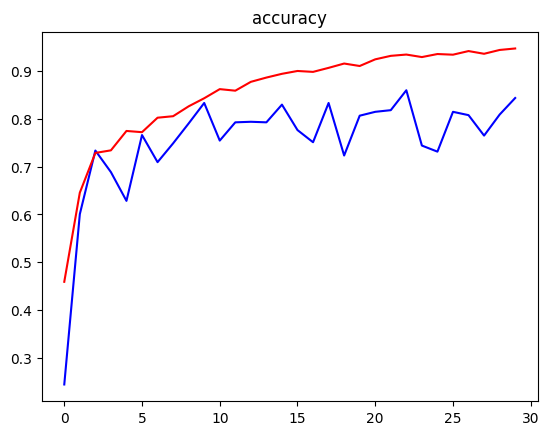

In [101]:
plt.plot(test_accs, 'b', train_accs, 'r')
plt.title('accuracy')
plt.show()

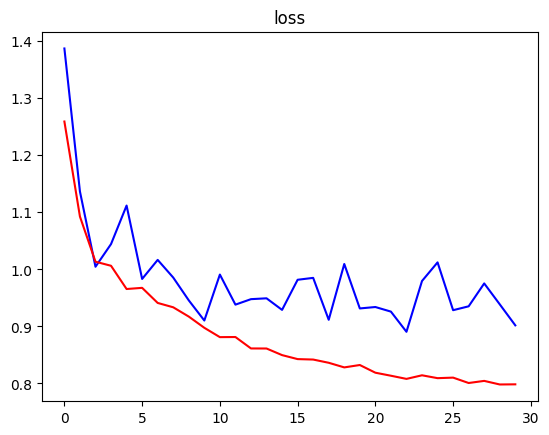

In [102]:
plt.plot(test_losses, 'b', train_losses, 'r')
plt.title('loss')
plt.show()

In [94]:
analysis_list = {'recall':0, 'percision':0, 'f1 score':0}
pred_analysis = {}

def calc_f1(label):
    return 2 * pred_analysis[label]['recall'] * pred_analysis[label]['percision'] / (pred_analysis[label]['recall'] + pred_analysis[label]['percision'])


true_predictions = {}
false_predictions = {}
total_predictions = {}

for label in df.labels:
    true_predictions[label] = 0
    false_predictions[label] = 0
    total_predictions[label] = 0
    pred_analysis[label] = deepcopy(analysis_list)

for i, pred in enumerate(pred_labels['pred']):
    actual = pred_labels['actual'][i]
    if actual == pred:
        true_predictions[pred] += 1
    else:
        false_predictions[pred] += 1
    total_predictions[actual] += 1

for label in df.labels:
    pred_analysis[label]['recall'] = true_predictions[label] / total_predictions[label]
    pred_analysis[label]['percision'] = true_predictions[label] / (true_predictions[label]+false_predictions[label])
    pred_analysis[label]['f1 score'] = calc_f1(label)

accuracy = np.array([pred_analysis[int(x)]['recall'] for x in pred_analysis.keys()]).mean()


print('accuracy is: ',accuracy)

for label in pred_analysis.keys():
    print(df.str_labels[int(label)], ': ')
    for factor in pred_analysis[label].keys():
        print('\t', factor, ' is: ', pred_analysis[label][factor])


accuracy is:  0.8189384739931188
pituitary : 
	 recall  is:  0.9833333333333333
	 percision  is:  0.855072463768116
	 f1 score  is:  0.9147286821705427
glioma : 
	 recall  is:  0.85
	 percision  is:  0.7846153846153846
	 f1 score  is:  0.816
notumor : 
	 recall  is:  0.9506172839506173
	 percision  is:  0.8555555555555555
	 f1 score  is:  0.9005847953216374
meningioma : 
	 recall  is:  0.4918032786885246
	 percision  is:  0.7894736842105263
	 f1 score  is:  0.6060606060606061


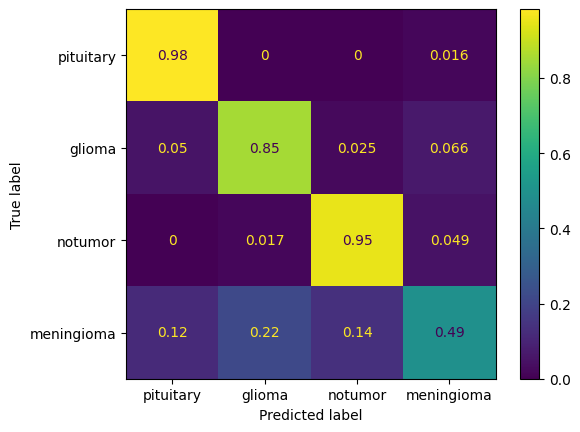

In [95]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf_matrix = confusion_matrix(pred_labels['actual'], pred_labels['pred']).astype('float')
conf_matrix /= conf_matrix.sum(axis=1)
ConfusionMatrixDisplay(conf_matrix, display_labels=df.str_labels).plot()
plt.show()

results indicate that model is good at detecting notumor and pituitary tumors and healthy brains, but confusion is high with meningioma type. since percision is high, we can train the model with more instances of meningioma to achieve better results, changing render type to RGB can be usefull as well. an additional change may be lowering the number of instances of notumor in dataloader since we initially had more notumor images.